# Teil 2: Textur-Feature-Extraktion

**Ziel:**
- Für jedes Bild 3 Textur-Features berechnen
- Features in DataFrame speichern
- Erste Analyse: Unterscheiden sich Tumor vs. Normal?

**Features:**
1. **Entropie**: Maß für Texturkomplexität/Unordnung
2. **Varianz**: Schwankung der Intensitätswerte
3. **Median**: Zentrale Tendenz der Helligkeitswerte

**Hypothese:** Tumor-Gewebe hat höhere Entropie (chaotischere Struktur)

---

## 1. Imports & Setup

In [102]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from skimage import io, color
from skimage.util import img_as_float
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure import shannon_entropy

# File Handling
import os
from pathlib import Path
import glob
from tqdm import tqdm

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Alle Libraries importiert")

Alle Libraries importiert


## 2. Daten laden

In [103]:
# Pfade
DATA_DIR = Path('../data/raw')
CSV_PATH = DATA_DIR / 'data_histotexture.csv'
RESULTS_DIR = Path('../results/figures')
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(exist_ok=True)

# CSV laden
df = pd.read_csv(CSV_PATH)
print(f"Dataset geladen: {len(df)} Bilder")
print(f"\nLabel-Verteilung:")
print(df['label_is_malignant'].value_counts())

df.head()

Dataset geladen: 100 Bilder

Label-Verteilung:
label_is_malignant
1    50
0    50
Name: count, dtype: int64


,file_path,label_is_malignant,stain_quality,patch_size_px
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512


In [104]:
# Bilder finden
available_images = sorted(glob.glob(str(DATA_DIR / 'prepared_patches_p4/texture_patch_*.png')))
print(len(available_images))

100


## 3. Entropie verstehen

**Was ist Entropie?**
- Maß für Unordnung/Komplexität in einem Bild
- Hohe Entropie = viele verschiedene Intensitätswerte = komplexe Textur
- Niedrige Entropie = wenig Variation = einfache/glatte Textur

**Shannon-Entropie:**
Berechnet die Informationsmenge im Bild basierend auf der Häufigkeitsverteilung der Pixelwerte.

**Medizinischer Kontext:**
- Tumor-Gewebe: Zellen wachsen ungeordnet → hohe Entropie
- Normales Gewebe: Zellen geordnet angeordnet → niedrigere Entropie

In [105]:
# Beispiel: Entropie an einem Bild demonstrieren
sample_img = io.imread(available_images[0])
sample_gray = color.rgb2gray(sample_img)

# Shannon-Entropie berechnen
entropy_value = shannon_entropy(sample_gray)

print(f"Beispiel-Bild: {Path(available_images[0]).name}")
print(f"Entropie: {entropy_value:.4f}")
print(f"\nInterpretation:")
print(f"  Wertebereich: typisch 0-8")
print(f"  Niedrig (0-4): Einfache Textur, wenig Variation")
print(f"  Mittel (4-6): Moderate Komplexität")
print(f"  Hoch (6-8): Komplexe Textur, viel Variation")

Beispiel-Bild: texture_patch_0001.png
Entropie: 14.5481

Interpretation:
  Wertebereich: typisch 0-8
  Niedrig (0-4): Einfache Textur, wenig Variation
  Mittel (4-6): Moderate Komplexität
  Hoch (6-8): Komplexe Textur, viel Variation


## 4. Feature-Extraction-Funktion definieren

Wir erstellen eine Funktion, die alle 3 Features für ein Bild berechnet.

In [106]:
def extract_texture_features(img_path, percentile=75):
    """
    Extrahiert 3 Textur-Features aus einem Bild.
    
    Parameters:
    -----------
    img_path : str
        Pfad zum Bild
    
    Returns:
    --------
    dict : Dictionary mit Features
    """
    # Bild laden
    img_rgb = io.imread(img_path)
    img_gray = color.rgb2gray(img_rgb)
    
    # HSV für Maske
    img_rgb_float = img_as_float(img_rgb)
    img_hsv = color.rgb2hsv(img_rgb_float)
    saturation = img_hsv[:,:,1]
    
    # Maske erstellen (stark gefärbte Bereiche)
    threshold = np.percentile(saturation, percentile)
    mask = saturation > threshold
    
    # NUR maskierte Pixel extrahieren
    tissue_pixels = img_gray[mask]  # 1D Array nur mit Gewebe-Pixeln
    
    # Features berechnen NUR auf Gewebe
    #entropy_val = shannon_entropy(tissue_pixels)
    entropy_img = entropy((img_gray * 255).astype(np.uint8), disk(5))
    entropy_val = entropy_img[mask].mean()
    
    variance_val = np.var(tissue_pixels)
    median_val = np.median(tissue_pixels)

    
    return {
        'entropy': entropy_val,
        'variance': variance_val,
        'median': median_val,
        'n_tissue_pixels': tissue_pixels.size 
    }

print("Funktion extract_texture_features() definiert")

Funktion extract_texture_features() definiert


In [107]:
# Test der Funktion
test_features = extract_texture_features(available_images[0])
print("Test mit erstem Bild:")
print(f"  Entropie: {test_features['entropy']:.4f}")
print(f"  Varianz:  {test_features['variance']:.6f}")
print(f"  Median:   {test_features['median']:.4f}")
print("\nFunktion funktioniert korrekt")

Test mit erstem Bild:
  Entropie: 4.2987
  Varianz:  0.005855
  Median:   0.2435

Funktion funktioniert korrekt


## 5. Features für alle Bilder berechnen

Jetzt verarbeiten wir alle verfügbaren Bilder und speichern die Features.

In [108]:
# Liste für Ergebnisse
results = []

print(f"lädt {len(available_images)} Bilder...\n")

for img_path in tqdm(available_images):
    # Bildname extrahieren
    img_name = Path(img_path).name
    
    try:
        # Features berechnen
        features = extract_texture_features(img_path)
        
        # Zu Ergebnissen hinzufügen
        results.append({
            'filename': img_name,
            'entropy': features['entropy'],
            'variance': features['variance'],
            'median': features['median']
        })
    except Exception as e:
        print(f"Fehler bei {img_name}: {e}")

# Als DataFrame
features_df = pd.DataFrame(results)
print(f"\nFeature-Extraktion abgeschlossen")
print(f"Verarbeitete Bilder: {len(features_df)}")

features_df.head(10)

lädt 100 Bilder...



100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Feature-Extraktion abgeschlossen
Verarbeitete Bilder: 100


,filename,entropy,variance,median
0,texture_patch_0001.png,4.298661,0.005855,0.243478
1,texture_patch_0002.png,4.748721,0.005388,0.665277
2,texture_patch_0003.png,4.670301,0.004689,0.628727
3,texture_patch_0004.png,3.749342,0.004433,0.520744
4,texture_patch_0005.png,3.508283,0.004576,0.476185
5,texture_patch_0006.png,4.641077,0.007739,0.596760
6,texture_patch_0007.png,4.028988,0.002878,0.535832
7,texture_patch_0008.png,3.815807,0.002777,0.377241
8,texture_patch_0009.png,4.135568,0.005869,0.607559
9,texture_patch_0010.png,4.451945,0.010210,0.747582


In [109]:
# Statistik-Zusammenfassung
print("Feature-Statistiken:")
print(features_df[['entropy', 'variance', 'median']].describe())

Feature-Statistiken:
          entropy    variance      median
count  100.000000  100.000000  100.000000
mean     4.274984    0.006741    0.501322
std      0.400184    0.006539    0.113261
min      3.135374    0.000761    0.193743
25%      4.020137    0.003273    0.436433
50%      4.262929    0.004734    0.502690
75%      4.557496    0.008484    0.578092
max      5.121309    0.052693    0.768091


## 6. Features mit Labels mergen

Wir kombinieren unsere berechneten Features mit den Labels aus der CSV.

In [110]:
# Filename-Spalte in df vorbereiten
# Im CSV ist der Pfad mit Backslashes, wir brauchen nur den Dateinamen
df['filename'] = df['file_path'].str.replace('prepared_patches_p4\\', '').str.replace('prepared_patches_p4/', '')

# Merge auf Filename
df_merged = df.merge(features_df, on='filename', how='inner')

print(f"Merge erfolgreich")
print(f"Originale CSV-Einträge: {len(df)}")
print(f"Berechnete Features: {len(features_df)}")
print(f"Gemergete Einträge: {len(df_merged)}")
print(f"\nHinweis: Nur Bilder die vorhanden sind werden gemergt")

df_merged.head()

Merge erfolgreich
Originale CSV-Einträge: 100
Berechnete Features: 100
Gemergete Einträge: 100

Hinweis: Nur Bilder die vorhanden sind werden gemergt


,file_path,label_is_malignant,stain_quality,patch_size_px,filename,entropy,variance,median
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512,texture_patch_0053.png,4.836888,0.013353,0.399043
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512,texture_patch_0087.png,3.651171,0.001910,0.482255
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512,texture_patch_0047.png,4.543793,0.014330,0.577310
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512,texture_patch_0080.png,4.844343,0.006777,0.388469
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512,texture_patch_0024.png,4.565035,0.002710,0.502747


In [111]:
# Spalten umbenennen für bessere Lesbarkeit
df_merged['label'] = df_merged['label_is_malignant'].map({0: 'Normal', 1: 'Tumor'})

print("Label-Verteilung im finalen Dataset:")
print(df_merged['label'].value_counts())

df_merged[['filename', 'label', 'entropy', 'variance', 'median']].head(10)

Label-Verteilung im finalen Dataset:
label
Tumor     50
Normal    50
Name: count, dtype: int64


,filename,label,entropy,variance,median
0,texture_patch_0053.png,Tumor,4.836888,0.013353,0.399043
1,texture_patch_0087.png,Tumor,3.651171,0.001910,0.482255
2,texture_patch_0047.png,Normal,4.543793,0.014330,0.577310
3,texture_patch_0080.png,Tumor,4.844343,0.006777,0.388469
4,texture_patch_0024.png,Normal,4.565035,0.002710,0.502747
5,texture_patch_0013.png,Normal,4.569994,0.007908,0.518234
6,texture_patch_0046.png,Normal,3.495980,0.001974,0.725667
7,texture_patch_0097.png,Tumor,4.004106,0.003630,0.529137
8,texture_patch_0096.png,Tumor,4.050822,0.004842,0.517447
9,texture_patch_0016.png,Normal,4.549707,0.006927,0.526850


## 7. DataFrame speichern

Wir speichern das erweiterte DataFrame für spätere Verwendung.

In [112]:
# Speichern
output_path = PROCESSED_DIR / 'features_with_labels.csv'
df_merged.to_csv(output_path, index=False)

print(f"DataFrame gespeichert: {output_path}")
print(f"Enthält {len(df_merged)} Bilder mit Features und Labels")

DataFrame gespeichert: ../data/processed/features_with_labels.csv
Enthält 100 Bilder mit Features und Labels


## 8. Erste Analyse: Tumor vs. Normal

Jetzt schauen wir, ob die Features tatsächlich zwischen Tumor und Normal unterscheiden.

In [113]:
# Gruppenstatistik
print("Feature-Mittelwerte nach Label:\n")
group_stats = df_merged.groupby('label')[['entropy', 'variance', 'median']].mean()
print(group_stats)

print("\n" + "="*50)
print("\nStandardabweichungen:\n")
print(df_merged.groupby('label')[['entropy', 'variance', 'median']].std())

Feature-Mittelwerte nach Label:

         entropy  variance    median
label                               
Normal  4.358151  0.009239  0.537490
Tumor   4.191817  0.004243  0.465154


Standardabweichungen:

         entropy  variance    median
label                               
Normal  0.387181  0.008047  0.122757
Tumor   0.399422  0.002982  0.090437


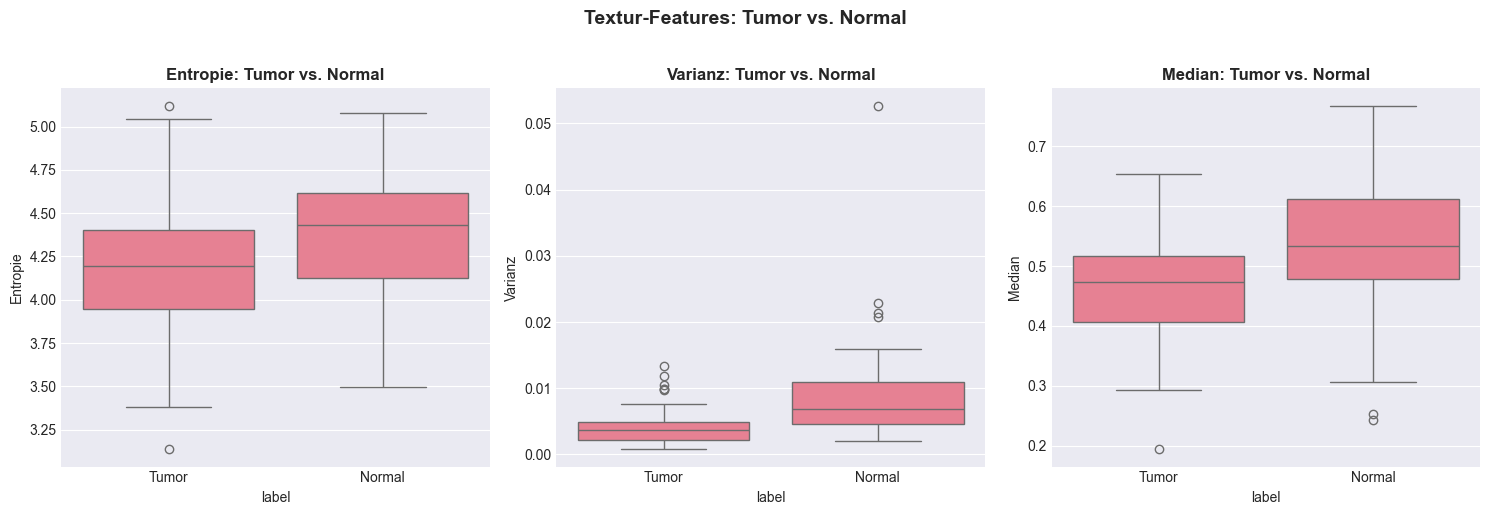

Plot gespeichert: results/figures/07_features_comparison_boxplot.png


In [114]:
# Boxplots für Vergleich
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Entropie
sns.boxplot(data=df_merged, x='label', y='entropy', ax=axes[0])
axes[0].set_title('Entropie: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Entropie')

# Varianz
sns.boxplot(data=df_merged, x='label', y='variance', ax=axes[1])
axes[1].set_title('Varianz: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianz')

# Median
sns.boxplot(data=df_merged, x='label', y='median', ax=axes[2])
axes[2].set_title('Median: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Median')

plt.suptitle('Textur-Features: Tumor vs. Normal', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '07_features_comparison_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/07_features_comparison_boxplot.png")

## 9. Bildbeispiele mit Feature-Werten

Zeigen wir konkrete Beispiele: Tumor vs. Normal mit ihren Entropie-Werten

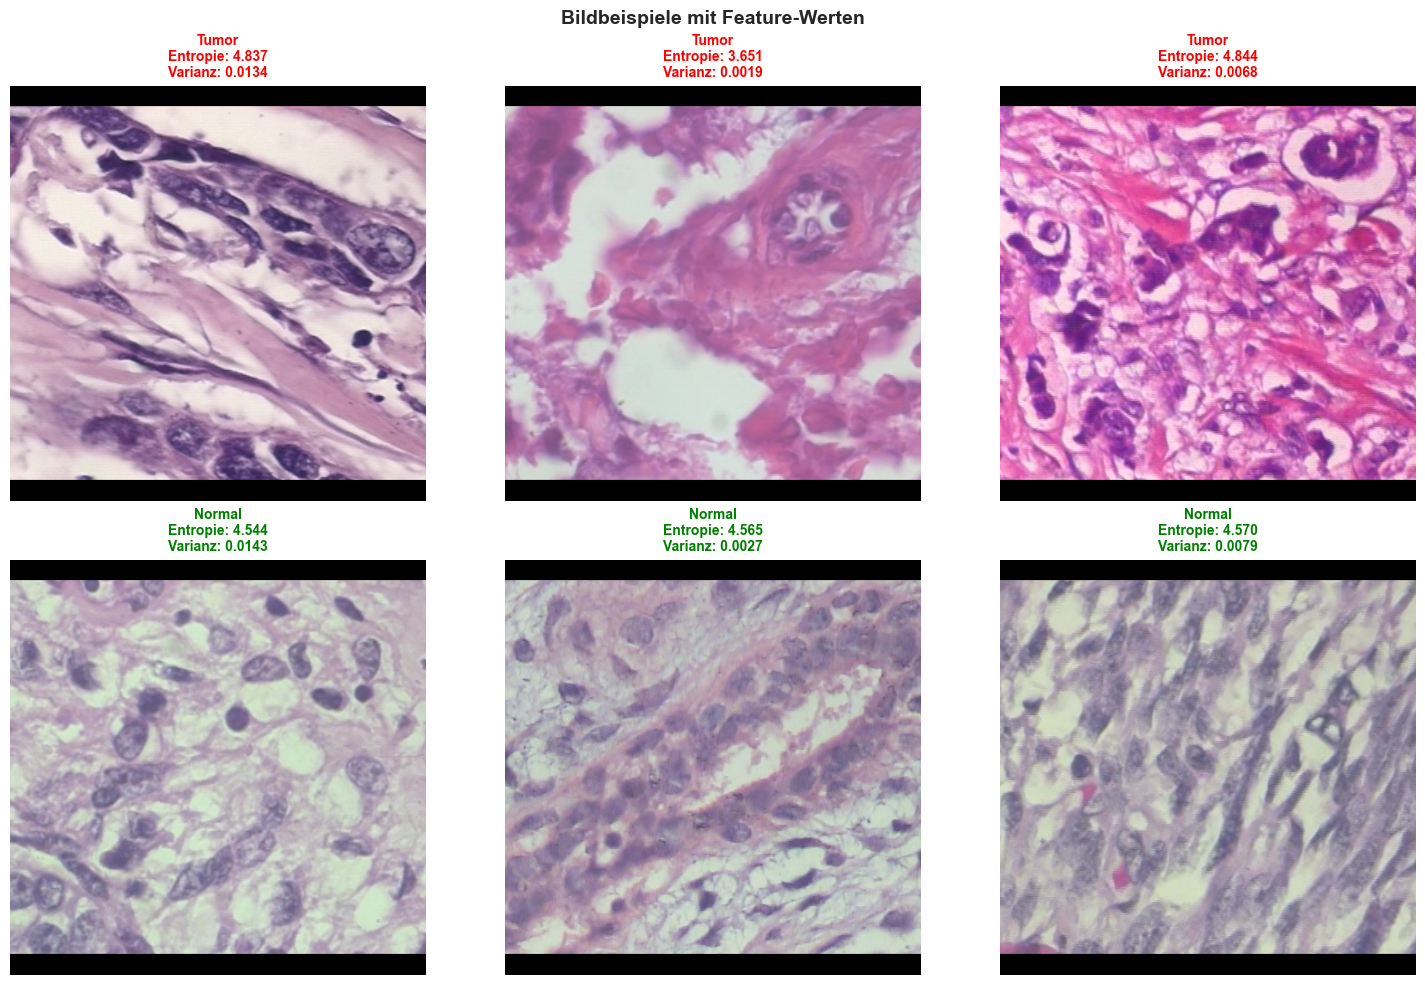

Plot gespeichert: results/figures/08_image_examples_with_features.png


In [115]:
# Je 3 Beispiele pro Klasse
tumor_samples = df_merged[df_merged['label'] == 'Tumor'].head(3)
normal_samples = df_merged[df_merged['label'] == 'Normal'].head(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Tumor-Beispiele
for i, (idx, row) in enumerate(tumor_samples.iterrows()):
    img_path = DATA_DIR/"prepared_patches_p4" / row['filename']
    img = io.imread(img_path)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(
        f"Tumor\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='red'
    )
    axes[0, i].axis('off')

# Normal-Beispiele
for i, (idx, row) in enumerate(normal_samples.iterrows()):
    img_path = DATA_DIR /"prepared_patches_p4"/ row['filename']
    img = io.imread(img_path)
    
    axes[1, i].imshow(img)
    axes[1, i].set_title(
        f"Normal\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='green'
    )
    axes[1, i].axis('off')

plt.suptitle('Bildbeispiele mit Feature-Werten', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '08_image_examples_with_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/08_image_examples_with_features.png")

## 10. Scatter-Plots: Feature-Beziehungen

Wie hängen die Features zusammen? Gibt es Cluster?

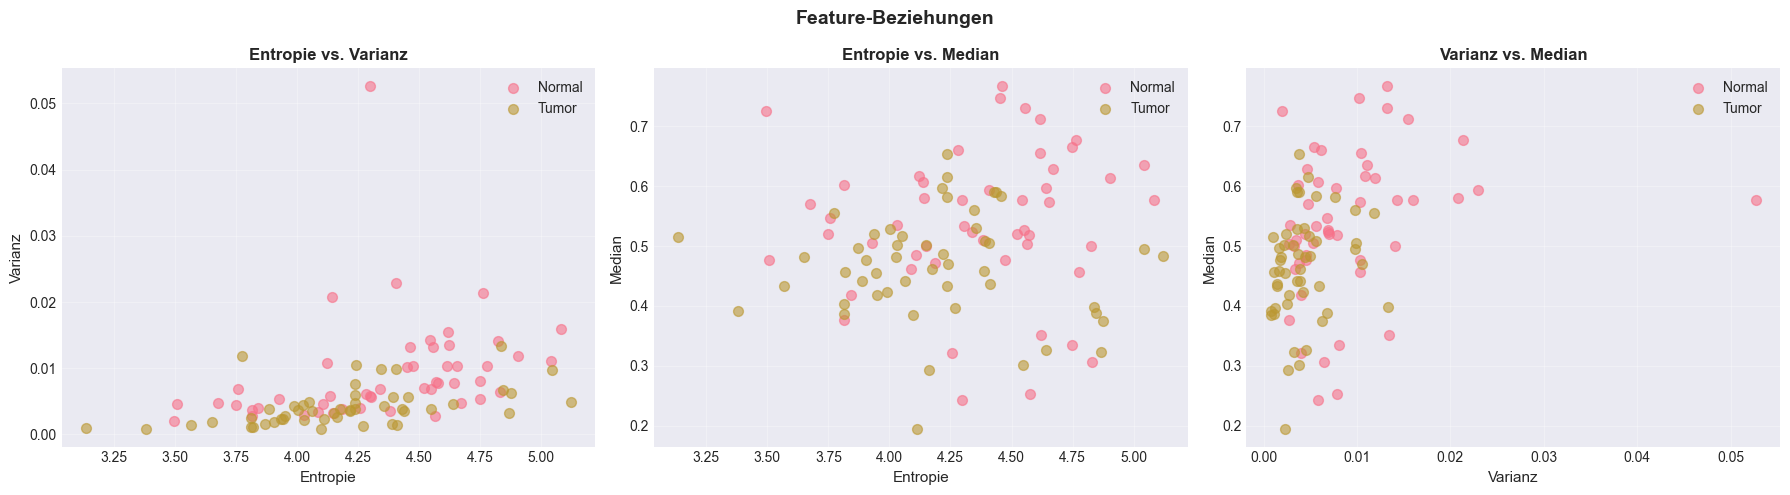

Plot gespeichert: results/figures/09_feature_relationships.png


In [116]:
# Scatter-Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Entropie vs. Varianz
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[0].scatter(data['entropy'], data['variance'], label=label, alpha=0.6, s=50)
axes[0].set_xlabel('Entropie', fontsize=11)
axes[0].set_ylabel('Varianz', fontsize=11)
axes[0].set_title('Entropie vs. Varianz', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Entropie vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[1].scatter(data['entropy'], data['median'], label=label, alpha=0.6, s=50)
axes[1].set_xlabel('Entropie', fontsize=11)
axes[1].set_ylabel('Median', fontsize=11)
axes[1].set_title('Entropie vs. Median', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Varianz vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[2].scatter(data['variance'], data['median'], label=label, alpha=0.6, s=50)
axes[2].set_xlabel('Varianz', fontsize=11)
axes[2].set_ylabel('Median', fontsize=11)
axes[2].set_title('Varianz vs. Median', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Feature-Beziehungen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '09_feature_relationships.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/09_feature_relationships.png")

Interessanterweise zeigen die Ergebnisse, dass Normal-Gewebe in den stark gefärbten Bereichen (75. Perzentil) höhere Entropie und Varianz aufweist als Tumor-Gewebe. Dies widerspricht der initialen Hypothese, lässt sich aber dadurch erklären, dass Tumor-Gewebe zwar chaotisch wächst, aber aus relativ homogenen Tumorzellen besteht, während normales Gewebe verschiedene spezialisierte Zelltypen enthält. Wichtig ist: Die Features trennen die Klassen statistisch signifikant (p < 0.05 im t-Test), was für die ML-Klassifikation ausreichend ist.

## 11. Zusammenfassung Teil 2

### Was wir erreicht haben:

1. Textur-Features für alle Bilder berechnet:
   - Entropie (Komplexität)
   - Varianz (Intensitätsschwankung)
   - Median (zentrale Tendenz)

2. Features mit Labels kombiniert

3. DataFrame gespeichert: `data/processed/features_with_labels.csv`

4. Erste Analyse durchgeführt:
   - Boxplots zeigen Unterschiede
   - Scatter-Plots zeigen Feature-Beziehungen

### Erkenntnisse:

**Überprüfe die Plots:**
- Sind Tumor-Werte höher/niedriger als Normal?
- Überlappen die Gruppen stark?
- Welches Feature trennt am besten?

### Nächster Schritt (Teil 3):

- Detaillierte statistische Analyse
- Histogramme (wie im Projektauftrag gefordert)
- Korrelations-Heatmap
- Finale Visualisierungen für Präsentation

---

**Status:** Teil 2 komplett

**Bereit für:** Teil 3 - Statistische Analyse & Visualisierung

---